# Step 1: Data Import

https://www.kaggle.com/code/ryuodan/asl-detection-walkthrough <br>
https://www.kaggle.com/code/razinw/asl-alphabet-classification-with-cnn

In [2]:
import os 
from os import listdir
from os.path import isfile, join
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import plot_roc_curve
import random
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras import utils
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras import layers, models
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import cross_val_score
import keras
import keras_metrics

We iterate through each subfolder in the train folder, and for each subfolder, we add the paths of the image files to our list. Then we convert this to a dataframe.

In [3]:
all_data = []
train_folder = r'archive\asl_alphabet_train\asl_alphabet_train'

for folder in os.listdir(train_folder):
    label_folder = os.path.join(train_folder, folder)
    onlyfiles = [{'label':folder,'path':os.path.join(label_folder, f)} for f in os.listdir(label_folder) 
                 if os.path.isfile(os.path.join(label_folder, f))]
    all_data += onlyfiles
    
data_df = pd.DataFrame(all_data)

In [6]:
data_df.iloc[0]['path']

'archive\\asl_alphabet_train\\asl_alphabet_train\\A\\A1.jpg'

# Step 2: Data Exploration

We perform exploratory analysis in order to view the distribution of our classes in our dataset. In addition, we provide previews of the original image and resized images to give a high-level overview of the types of inputs our models will be performing predictive analyses on.

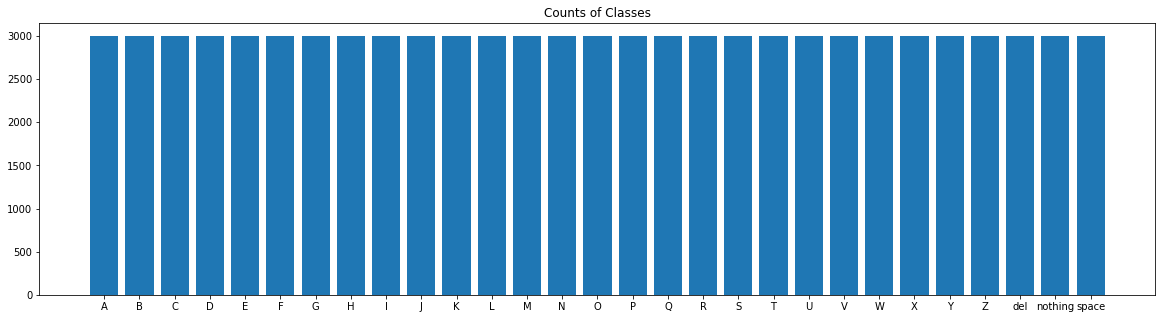

In [3]:
counts = data_df.groupby(by='label').size().to_frame(name='vals')

plt.figure(figsize=(20, 5))
plt.bar(counts.index, counts.vals)
plt.title('Counts of Classes')
plt.show()

In [4]:
signs = data_df['label'].unique().tolist()

def show_image(label, signs, size):
    if label not in signs:
        print('Error: Unknown Label')
        return 0
    rows = data_df[data_df['label']==label]['path']
    rand_img = random.randint(a=0, b=len(rows))
    filepath = rows.iloc[rand_img]
    img = cv2.imread(filepath)
    img = cv2.resize(img, size)
    plt.figure()
    plt.title(label + " with size " + str(size))
    plt.imshow(img)

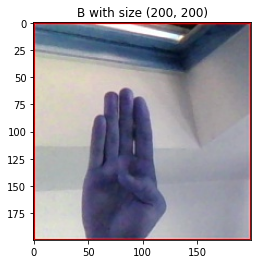

In [5]:
original_size = 200, 200
show_image('B', signs, original_size)

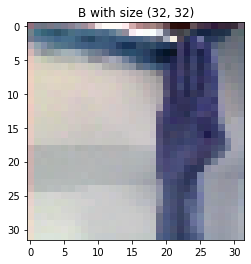

In [6]:
ideal_size = 32, 32
show_image('B', signs, ideal_size)

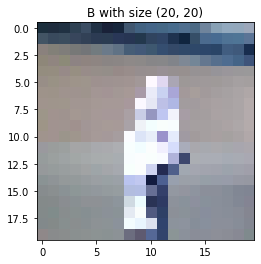

In [7]:
reduced_size = 20, 20
show_image('B', signs, reduced_size)

# Step 3: Data Processing

We use the cv2 package to read an image from a filepath and resize it. We then convert the image to an numpy array of values between 0 and 255. This way, we can feed our data into our models.

In [8]:
def encode_imgs(paths, size):
    res = []
    for path in paths:
        img = cv2.imread(path)
        img = cv2.resize(img, size)
        res.append(img)
    res = np.array(res)
    res = res.astype('float32')/255.0
    return res

# Step 4: Data Modeling

First, we establish a logistic regression model as a baseline, mainly to illustrate that this problem is solvable through machine learning. Logistic regression is relatively more simple than the neural networks we build, so we predict our neural networks will perform at least as well as this logistic regression model.

In [30]:
def run_logr(data_df, label1, label2, size):
    binary_df = data_df.loc[(data_df['label'] == label1) | (data_df['label'] == label2)]
    encoded = encode_imgs(binary_df['path'], size)
    print('Data Encoded!\n')
    X_train, X_test, y_train, y_test = train_test_split(encoded, binary_df['label'], random_state = 3000)
    X_train = X_train.reshape(X_train.shape[0], X_train.shape[1] * X_train.shape[2] * X_train.shape[3])
    X_test = X_test.reshape(X_test.shape[0], X_test.shape[1] * X_test.shape[2] * X_test.shape[3])
    
    lr = LogisticRegression()
    lr.fit(X_train, y_train)
    print('Model fitted!\n')

    y_pred_test = lr.predict(X_test)
    print('Predictions made!\n')
    print('Confusion Matrix: \n')
    print(confusion_matrix(y_test, y_pred_test))
    test_acc = accuracy_score(y_test, y_pred_test)
    test_f1 = f1_score(y_test, y_pred_test, pos_label=label1)
    test_rec = recall_score(y_test, y_pred_test, pos_label=label1)
    test_pre = precision_score(y_test, y_pred_test, pos_label=label1)
    plot_roc_curve(lr, X_test, y_test, pos_label=label1) 
    plt.show()

    print('Logistic Regression Metrics: ' + label1 + ' and ' + label2)
    print('Testing Accuracy: ' + str(test_acc))
    print('Testing F1 Score: ' + str(test_f1))
    print('Testing Recall: ' + str(test_rec))
    print('Testing Precision: ' + str(test_pre))

## Logistic Regression: Two "Similar" Signs

The letter A and the letter B have similar signs, so let's see how our Logistic Regression model performs.

Data Encoded!



C:\Users\Justin\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\linear_model\_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
C:\Users\Justin\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


Model fitted!

Predictions made!

Confusion Matrix: 

[[640  72]
 [ 76 712]]


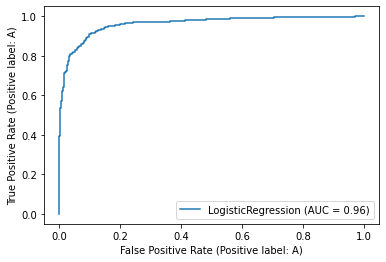

Logistic Regression Metrics: A and B
Testing Accuracy: 0.9013333333333333
Testing F1 Score: 0.896358543417367
Testing Recall: 0.898876404494382
Testing Precision: 0.8938547486033519


In [31]:
run_logr(data_df, 'A', 'B', ideal_size)

## Logistic Regression: Two "Different" Signs

The letters C and G are vastly different signs, so let's see how our Logistic Regression model performs.

Data Encoded!



C:\Users\Justin\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\linear_model\_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
C:\Users\Justin\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


Model fitted!

Predictions made!

Confusion Matrix: 

[[712   0]
 [  0 788]]


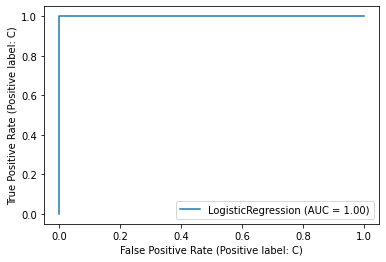

Logistic Regression Metrics: C and G
Testing Accuracy: 1.0
Testing F1 Score: 1.0
Testing Recall: 1.0
Testing Precision: 1.0


In [32]:
run_logr(data_df, 'C', 'G', ideal_size)

# Building Neural Networks
First, we encode the data to ideal size (32, 32) and the reduced size (20, 20).

In [12]:
encoded_data = encode_imgs(data_df['path'], ideal_size)
reduced_data = encode_imgs(data_df['path'], reduced_size)

In [13]:
le = preprocessing.LabelEncoder()
le.fit(data_df.label)
data_df['categorical_label'] = le.transform(data_df.label)

# NN 1
3 hidden layers (20, 40, 40 filters), input size (20, 20)

# NN 2
3 hidden layers (32, 64, 64 filters), input size (32, 32)

# NN 3
3 hidden layers (45, 90, 90 filters), input size (32, 32)

In [14]:
model1 = models.Sequential()
model1.add(layers.Conv2D(20, (3, 3), activation='relu', input_shape=(20, 20, 3)))
model1.add(layers.MaxPooling2D((2, 2)))
model1.add(layers.Conv2D(40, (3, 3), activation='relu'))
model1.add(layers.MaxPooling2D((2, 2)))
model1.add(layers.Conv2D(40, (3, 3), activation='relu'))
model1.add(layers.Flatten())
model1.add(layers.Dense(40, activation='relu'))
model1.add(layers.Dense(29))

model1.summary()

model2 = models.Sequential()
model2.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
model2.add(layers.MaxPooling2D((2, 2)))
model2.add(layers.Conv2D(64, (3, 3), activation='relu'))
model2.add(layers.MaxPooling2D((2, 2)))
model2.add(layers.Conv2D(64, (3, 3), activation='relu'))
model2.add(layers.Flatten())
model2.add(layers.Dense(64, activation='relu'))
model2.add(layers.Dense(29))

model2.summary()

model3 = models.Sequential()
model3.add(layers.Conv2D(45, (3, 3), activation='relu', input_shape=(32, 32, 3)))
model3.add(layers.MaxPooling2D((2, 2)))
model3.add(layers.Conv2D(90, (3, 3), activation='relu'))
model3.add(layers.MaxPooling2D((2, 2)))
model3.add(layers.Conv2D(90, (3, 3), activation='relu'))
model3.add(layers.Flatten())
model3.add(layers.Dense(90, activation='relu'))
model3.add(layers.Dense(29))

model3.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 18, 18, 20)        560       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 9, 9, 20)         0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 40)          7240      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 3, 3, 40)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 1, 1, 40)          14440     
                                                                 
 flatten (Flatten)           (None, 40)                0

# NN 4
1 hidden layer (32 filters), input size (32, 32)

In [15]:
model4 = models.Sequential()
model4.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
model4.add(layers.MaxPooling2D((2, 2)))
model4.add(layers.Flatten())
model4.add(layers.Dense(32, activation='relu'))
model4.add(layers.Dense(29))

model4.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 15, 15, 32)       0         
 2D)                                                             
                                                                 
 flatten_3 (Flatten)         (None, 7200)              0         
                                                                 
 dense_6 (Dense)             (None, 32)                230432    
                                                                 
 dense_7 (Dense)             (None, 29)                957       
                                                                 
Total params: 232,285
Trainable params: 232,285
Non-trainable params: 0
________________________________________________

In [16]:
def run_nn(model, optimizer, epochs, batch_size, data_df, data):
    X_train, X_test, y_train, y_test = train_test_split(data, data_df['categorical_label'], random_state = 3000)
    
    model.compile(optimizer=optimizer,
                 loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                 metrics=['accuracy'])
    
    history = model.fit(X_train, y_train, epochs=5, batch_size = 64, shuffle=True, validation_data=(X_test, y_test))
    metrics = pd.DataFrame(history.history)
    
    print('\n----------------------\n')
    print(metrics)
    
    y_pred_test = model.predict(X_test)
    y_test_classes =np.argmax(y_pred_test,axis=1)
    
    confusion = confusion_matrix(y_test, y_test_classes)
    confusion_df = pd.DataFrame(confusion)
    confusion_df.index = sorted(list(set(data_df['label'])))

    acc_test = accuracy_score(y_test, y_test_classes)
    f1_test = f1_score(y_test, y_test_classes, average='weighted')
    prec_test = precision_score(y_test, y_test_classes, average='weighted')
    rec_test = recall_score(y_test, y_test_classes, average='weighted')

    print("\n-----------------------\n")
    print("Accuracy on testing set: ", acc_test)
    print("F1 score on testing set: ", f1_test)
    print("Precision on testing set: ", prec_test)
    print("Recall on testing set: ", rec_test)
    
    return confusion_df

In [17]:
confusion_df1 = run_nn(model1, 'adam', 5, 64, data_df, reduced_data)
confusion_df1

Epoch 1/5
1020/1020 [==============================] - 21s 20ms/step - loss: 2.2994 - accuracy: 0.3095 - val_loss: 1.6304 - val_accuracy: 0.4850
Epoch 2/5
1020/1020 [==============================] - 20s 19ms/step - loss: 1.3015 - accuracy: 0.5826 - val_loss: 1.1617 - val_accuracy: 0.6150
Epoch 3/5
1020/1020 [==============================] - 20s 19ms/step - loss: 0.9439 - accuracy: 0.6885 - val_loss: 0.8558 - val_accuracy: 0.7206
Epoch 4/5
1020/1020 [==============================] - 20s 19ms/step - loss: 0.7442 - accuracy: 0.7521 - val_loss: 0.7209 - val_accuracy: 0.7572
Epoch 5/5
1020/1020 [==============================] - 20s 19ms/step - loss: 0.6109 - accuracy: 0.7926 - val_loss: 0.5775 - val_accuracy: 0.8051

----------------------

       loss  accuracy  val_loss  val_accuracy
0  2.299420  0.309487  1.630377      0.485011
1  1.301513  0.582559  1.161728      0.615034
2  0.943867  0.688460  0.855777      0.720552
3  0.744210  0.752077  0.720926      0.757241
4  0.610949  0.79261

,0,1,2,3,4,5,6,7,8,9,...,19,20,21,22,23,24,25,26,27,28
A,555,30,0,4,57,5,0,0,3,0,...,4,0,0,0,0,3,0,0,0,0
B,3,576,1,4,79,2,1,0,16,0,...,0,7,16,1,0,0,0,0,0,1
C,5,2,689,8,1,4,0,0,0,0,...,0,1,0,0,0,0,0,1,0,0
D,1,11,2,647,19,31,2,0,6,0,...,1,2,0,0,0,0,1,2,0,8
E,24,40,0,4,607,25,7,0,11,0,...,1,0,0,0,0,0,0,0,0,0
F,0,0,1,0,7,648,19,0,15,1,...,0,0,0,0,0,15,0,0,0,3
G,0,0,0,0,0,9,639,44,7,19,...,0,0,0,0,0,0,0,0,0,1
H,0,0,0,0,0,0,25,695,3,5,...,0,0,0,0,0,0,0,0,4,1
I,0,0,0,2,5,4,19,0,664,20,...,0,0,9,1,1,1,0,2,0,0
J,0,0,0,0,0,0,6,4,5,709,...,0,0,0,0,0,1,0,0,0,1


In [18]:
confusion_df2 = run_nn(model2, 'adam', 5, 64, data_df, encoded_data)
confusion_df2

Epoch 1/5
1020/1020 [==============================] - 78s 76ms/step - loss: 1.4665 - accuracy: 0.5528 - val_loss: 0.5729 - val_accuracy: 0.8127
Epoch 2/5
1020/1020 [==============================] - 78s 76ms/step - loss: 0.3923 - accuracy: 0.8691 - val_loss: 0.3030 - val_accuracy: 0.8900
Epoch 3/5
1020/1020 [==============================] - 77s 76ms/step - loss: 0.2001 - accuracy: 0.9331 - val_loss: 0.1524 - val_accuracy: 0.9492
Epoch 4/5
1020/1020 [==============================] - 77s 76ms/step - loss: 0.1225 - accuracy: 0.9596 - val_loss: 0.1301 - val_accuracy: 0.9551
Epoch 5/5
1020/1020 [==============================] - 78s 77ms/step - loss: 0.0859 - accuracy: 0.9722 - val_loss: 0.0921 - val_accuracy: 0.9696

----------------------

       loss  accuracy  val_loss  val_accuracy
0  1.466454  0.552751  0.572889      0.812690
1  0.392285  0.869149  0.303043      0.889977
2  0.200150  0.933073  0.152425      0.949195
3  0.122524  0.959602  0.130149      0.955126
4  0.085860  0.97218

,0,1,2,3,4,5,6,7,8,9,...,19,20,21,22,23,24,25,26,27,28
A,715,0,0,1,0,0,0,0,0,0,...,2,0,0,0,0,0,5,0,0,0
B,0,714,0,7,5,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
C,0,0,727,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
D,0,0,0,753,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
E,8,2,0,7,734,6,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
F,0,0,0,0,0,724,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
G,0,0,0,0,0,7,711,0,1,0,...,0,0,0,0,0,4,0,0,0,0
H,0,0,0,0,0,0,7,732,0,0,...,0,0,0,0,0,0,0,0,0,0
I,0,0,0,0,0,3,0,0,744,0,...,0,0,0,0,0,1,0,0,0,0
J,0,0,0,0,0,0,2,0,1,728,...,0,0,0,0,0,5,0,0,0,0


In [19]:
confusion_df3 = run_nn(model3, 'adam', 5, 64, data_df, encoded_data)
confusion_df3

Epoch 1/5
1020/1020 [==============================] - 118s 114ms/step - loss: 1.3295 - accuracy: 0.5916 - val_loss: 0.4815 - val_accuracy: 0.8393
Epoch 2/5
1020/1020 [==============================] - 116s 114ms/step - loss: 0.3239 - accuracy: 0.8930 - val_loss: 0.2108 - val_accuracy: 0.9303
Epoch 3/5
1020/1020 [==============================] - 115s 112ms/step - loss: 0.1550 - accuracy: 0.9492 - val_loss: 0.0984 - val_accuracy: 0.9689
Epoch 4/5
1020/1020 [==============================] - 115s 113ms/step - loss: 0.1004 - accuracy: 0.9671 - val_loss: 0.1049 - val_accuracy: 0.9626
Epoch 5/5
1020/1020 [==============================] - 119s 117ms/step - loss: 0.0701 - accuracy: 0.9779 - val_loss: 0.0802 - val_accuracy: 0.9720

----------------------

       loss  accuracy  val_loss  val_accuracy
0  1.329503  0.591586  0.481489      0.839264
1  0.323881  0.892981  0.210805      0.930299
2  0.155001  0.949241  0.098398      0.968874
3  0.100413  0.967111  0.104922      0.962575
4  0.07014

,0,1,2,3,4,5,6,7,8,9,...,19,20,21,22,23,24,25,26,27,28
A,719,2,0,0,3,0,0,0,0,0,...,2,0,0,0,0,0,0,0,0,0
B,0,736,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
C,0,0,727,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
D,0,0,1,738,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
E,8,33,1,0,702,2,0,0,0,0,...,2,0,0,0,0,0,0,0,0,0
F,0,0,0,0,0,723,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
G,0,0,0,0,0,0,721,2,0,0,...,0,0,0,0,0,0,0,0,0,0
H,0,0,0,0,0,0,0,739,0,0,...,0,0,0,0,0,0,0,0,0,0
I,0,4,0,2,2,0,0,4,724,0,...,0,0,0,9,0,0,0,0,0,0
J,0,0,0,0,0,0,0,0,0,723,...,0,0,0,0,0,13,0,0,0,0


In [20]:
confusion_df4 = run_nn(model4, 'adam', 5, 64, data_df, encoded_data)
confusion_df4

Epoch 1/5
1020/1020 [==============================] - 46s 44ms/step - loss: 2.7771 - accuracy: 0.1560 - val_loss: 2.2759 - val_accuracy: 0.2635
Epoch 2/5
1020/1020 [==============================] - 45s 44ms/step - loss: 2.0881 - accuracy: 0.3065 - val_loss: 1.9190 - val_accuracy: 0.3652
Epoch 3/5
1020/1020 [==============================] - 45s 44ms/step - loss: 1.8171 - accuracy: 0.3849 - val_loss: 1.7247 - val_accuracy: 0.4143
Epoch 4/5
1020/1020 [==============================] - 45s 44ms/step - loss: 1.6346 - accuracy: 0.4356 - val_loss: 1.5727 - val_accuracy: 0.4472
Epoch 5/5
1020/1020 [==============================] - 45s 44ms/step - loss: 1.5049 - accuracy: 0.4741 - val_loss: 1.4423 - val_accuracy: 0.4953

----------------------

       loss  accuracy  val_loss  val_accuracy
0  2.777118  0.155954  2.275889      0.263494
1  2.088121  0.306529  1.918957      0.365195
2  1.817104  0.384889  1.724670      0.414253
3  1.634560  0.435556  1.572677      0.447172
4  1.504934  0.47410

,0,1,2,3,4,5,6,7,8,9,...,19,20,21,22,23,24,25,26,27,28
A,364,22,6,23,77,146,1,0,65,1,...,0,0,0,0,0,0,0,0,0,0
B,52,265,0,49,3,256,0,0,19,5,...,0,0,0,2,0,0,0,0,0,0
C,5,0,545,24,33,0,0,0,42,29,...,0,0,0,0,0,0,0,0,0,0
D,29,68,20,370,20,114,0,0,97,0,...,2,0,0,0,0,0,0,0,0,0
E,217,38,25,53,218,80,22,0,50,2,...,4,0,0,0,0,0,0,0,2,0
F,71,87,16,24,70,359,0,0,53,0,...,0,0,0,0,0,0,0,0,0,0
G,4,0,0,0,0,0,506,130,0,76,...,0,0,0,0,0,0,0,1,1,2
H,0,0,0,0,0,0,257,376,0,68,...,0,0,0,0,0,0,0,7,0,0
I,12,5,26,48,48,4,0,0,354,15,...,6,0,0,0,0,0,0,0,0,0
J,0,0,11,0,0,0,21,103,6,435,...,0,0,0,0,0,0,0,3,0,0


In [27]:
def run_kfold_nn(model, epochs, batch_size, encoded_data, data_df, cv):
    kc = KerasClassifier(model = model, epochs = epochs, batch_size = batch_size, verbose=1)
    cvs = cross_val_score(kc, encoded_data, data_df['label'], cv = cv)
    return cvs

In [28]:
cvs1 = run_kfold_nn(model1, 1, 64, reduced_data, data_df, 3)
cvs2 = run_kfold_nn(model2, 1, 64, encoded_data, data_df, 3)
cvs3 = run_kfold_nn(model3, 1, 64, encoded_data, data_df, 3)
cvs4 = run_kfold_nn(model4, 1, 64, encoded_data, data_df, 3)


INFO:tensorflow:Assets written to: C:\Users\Justin\AppData\Local\Temp\tmp4_n1kb_z\assets
454/454 [==============================] - 3s 7ms/step
INFO:tensorflow:Assets written to: C:\Users\Justin\AppData\Local\Temp\tmpfh8i06jc\assets
454/454 [==============================] - 3s 7ms/step
INFO:tensorflow:Assets written to: C:\Users\Justin\AppData\Local\Temp\tmp2pd19ms5\assets
454/454 [==============================] - 3s 7ms/step
INFO:tensorflow:Assets written to: C:\Users\Justin\AppData\Local\Temp\tmpdwaohslq\assets
454/454 [==============================] - 7s 15ms/step
INFO:tensorflow:Assets written to: C:\Users\Justin\AppData\Local\Temp\tmpjuvrd701\assets
454/454 [==============================] - 8s 18ms/step
INFO:tensorflow:Assets written to: C:\Users\Justin\AppData\Local\Temp\tmp9lt4ik9l\assets
454/454 [==============================] - 7s 15ms/step
INFO:tensorflow:Assets written to: C:\Users\Justin\AppData\Local\Temp\tmp4y2pw4qo\assets
454/454 [==============================] - 1

In [29]:
print(cvs1)
print(cvs2)
print(cvs3)
print(cvs4)

[0.74272414 0.64634483 0.80265517]
[0.94337931 0.84306897 0.96455172]
[0.88506897 0.92241379 0.95137931]
[0.42844828 0.32713793 0.52306897]
